In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-23 12:02:31,811 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        best_cost = 0
        r2_scores = {}
        for col in y_pred.drop(columns=['electrode', 'image']).columns:
            yt = np.array(y.loc[:, col], dtype=float)
            yp = np.array(y_pred.loc[:, col], dtype=float)

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                # ss_tot = np.sum((yt - np.mean(yt)) ** 2)
                ss_tot = spst.circvar(yt, low=-np.pi / 2, high=np.pi / 2)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
            'best_cost': best_cost,
            'n_samples': len(yt),
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
#         row.update(best_params)
        row.update(r2_scores)
        data.append(row)
    return pd.DataFrame(data)

In [3]:
results_dir = '../../results/shape5fit/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 18 files


In [4]:
subjects = ['12-005', '51-009', '52-001', 'TB']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [5]:
data = load_data(pickle_files, verbose=False)
data

,adjust_bias,best_cost,exetime,filename,filepath,model,n_samples,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject
0,False,5.462424,1236.755252,12-005_C__shape5fit-swarm_2018-04-23_00-41-26....,../../results/shape5fit,C,15,0.064571,-0.465916,-1.263949,0.202870,12-005
1,False,5.470016,2035.161238,12-005_C__shape5fit-swarm_2018-04-23_01-02-08....,../../results/shape5fit,C,15,-0.000281,-0.375821,-1.270058,0.176144,12-005
2,False,5.386819,2361.856219,12-005_C__shape5fit-swarm_2018-04-23_01-36-09....,../../results/shape5fit,C,15,0.074519,-0.358910,-1.276631,0.174204,12-005
3,False,5.544964,15100.868391,12-005_C__shape5fit-swarm_2018-04-23_02-15-46....,../../results/shape5fit,C,15,0.097315,-0.455426,-1.343104,0.156252,12-005
4,False,5.705868,13031.318759,12-005_C__shape5fit-swarm_2018-04-23_06-27-42....,../../results/shape5fit,C,15,-0.110539,-0.625960,-1.213731,0.244363,12-005
5,False,98.154378,8394.181370,51-009_C__shape5fit-swarm_2018-04-23_00-41-39....,../../results/shape5fit,C,14,-15.519057,-3.225253,-75.064634,-0.345434,51-009
6,False,105.611337,5976.251778,51-009_C__shape5fit-swarm_2018-04-23_03-01-47....,../../results/shape5fit,C,14,-18.428252,-3.009291,-80.066194,-0.107599,51-009
7,False,1252.623062,14762.266709,51-009_C__shape5fit-swarm_2018-04-23_04-41-37....,../../results/shape5fit,C,14,-0.659454,-2.712705,-1245.084568,-0.166335,51-009
8,False,2.974167,1288.800973,52-001_C__shape5fit-swarm_2018-04-23_00-42-09....,../../results/shape5fit,C,16,0.275519,-0.298944,0.324357,0.724900,52-001
9,False,2.993184,1834.967942,52-001_C__shape5fit-swarm_2018-04-23_01-03-45....,../../results/shape5fit,C,16,0.289600,-0.304151,0.300214,0.721153,52-001


In [6]:
data.n_samples.unique()

array([15, 14, 16, 11])

# All runs

In [7]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
r2cols = ['r2_area', 'r2_orientation', 'r2_eccentricity', 'r2_compactness']

In [8]:
data.groupby(groupcols)['exetime', 'best_cost'].agg(['mean', 'std', 'count'])

exetime                      best_cost  \
                                  mean          std count        mean   
subject model adjust_bias                                               
12-005  C     False        6753.191972  6728.173886     5    5.514018   
51-009  C     False        9710.899952  4538.592894     3  485.462926   
52-001  C     False        1520.776261   295.399132     5    2.985443   
TB      C     False        4195.114809  1887.306056     5   11.128337   

                                             
                                  std count  
subject model adjust_bias                    
12-005  C     False          0.120977     5  
51-009  C     False        664.390629     3  
52-001  C     False          0.011145     5  
TB      C     False          0.217993     5

# The best runs in their respective category

In [9]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols)['best_cost'].transform(np.min) == data['best_cost']
data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols).min()

Best scores:


,,,best_cost,r2_area,r2_compactness,r2_eccentricity,r2_orientation
subject,model,adjust_bias,,,,,
12-005,C,False,5.386819,0.074519,-0.358910,-1.276631,0.174204
51-009,C,False,98.154378,-15.519057,-3.225253,-75.064634,-0.345434
52-001,C,False,2.972390,0.264031,-0.306596,0.344459,0.725716
TB,C,False,10.793146,-3.292036,-0.604071,-0.741915,-2.155123


# Runs that give sufficiently good results

Predicts all four parameters:

In [10]:
best = data.loc[best_idx, :]
best4_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best4_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

""


Predicts at least 3 out of 4:

In [11]:
best3_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
best3_idx |= (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best3_idx |= (best['r2_eccentricity'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best3_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best3_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

,,,best_cost,filename,r2_area,r2_compactness,r2_eccentricity,r2_orientation
subject,model,adjust_bias,,,,,,
52-001,C,False,2.97239,52-001_C__shape5fit-swarm_2018-04-23_02-21-01....,0.264031,-0.306596,0.344459,0.725716


Predicts at least 2 out of 4:

In [12]:
best2_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0)
best2_idx |= (best['r2_area'] > 0) & (best['r2_compactness'] > 0)
best2_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0)
best2_idx |= (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best2_idx |= (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
best2_idx |= (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best2_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

,,,best_cost,filename,r2_area,r2_compactness,r2_eccentricity,r2_orientation
subject,model,adjust_bias,,,,,,
12-005,C,False,5.386819,12-005_C__shape5fit-swarm_2018-04-23_01-36-09....,0.074519,-0.358910,-1.276631,0.174204
52-001,C,False,2.972390,52-001_C__shape5fit-swarm_2018-04-23_02-21-01....,0.264031,-0.306596,0.344459,0.725716


In [13]:
best1_idx = (best['r2_area'] > 0)
best1_idx |= (best['r2_compactness'] > 0)
best1_idx |= (best['r2_eccentricity'] > 0)
best1_idx |= (best['r2_orientation'] > -20)
best.loc[best1_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

,,,best_cost,filename,r2_area,r2_compactness,r2_eccentricity,r2_orientation
subject,model,adjust_bias,,,,,,
12-005,C,False,5.386819,12-005_C__shape5fit-swarm_2018-04-23_01-36-09....,0.074519,-0.358910,-1.276631,0.174204
51-009,C,False,98.154378,51-009_C__shape5fit-swarm_2018-04-23_00-41-39....,-15.519057,-3.225253,-75.064634,-0.345434
52-001,C,False,2.972390,52-001_C__shape5fit-swarm_2018-04-23_02-21-01....,0.264031,-0.306596,0.344459,0.725716
TB,C,False,10.793146,TB_C__shape5fit-swarm_2018-04-23_02-50-57.pickle,-3.292036,-0.604071,-0.741915,-2.155123


In [14]:
plot_files = best.loc[best1_idx, :].reset_index()

In [15]:
plot_files

,index,adjust_bias,best_cost,exetime,filename,filepath,model,n_samples,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject
0,2,False,5.386819,2361.856219,12-005_C__shape5fit-swarm_2018-04-23_01-36-09....,../../results/shape5fit,C,15,0.074519,-0.358910,-1.276631,0.174204,12-005
1,5,False,98.154378,8394.181370,51-009_C__shape5fit-swarm_2018-04-23_00-41-39....,../../results/shape5fit,C,14,-15.519057,-3.225253,-75.064634,-0.345434,51-009
2,12,False,2.972390,1708.844736,52-001_C__shape5fit-swarm_2018-04-23_02-21-01....,../../results/shape5fit,C,16,0.264031,-0.306596,0.344459,0.725716,52-001
3,15,False,10.793146,6808.831457,TB_C__shape5fit-swarm_2018-04-23_02-50-57.pickle,../../results/shape5fit,C,11,-3.292036,-0.604071,-0.741915,-2.155123,TB


In [16]:
y, _, _, _ = pickle.load(open(os.path.join(*plot_files.loc[plot_files.index[0], ['filepath', 'filename']]), 'rb'))
if isinstance(y, list):
    y = pd.concat(y)
columns = y.drop(columns=['electrode', 'image']).columns
columns

Index(['area', 'compactness', 'eccentricity', 'orientation'], dtype='object')

# Plot best ones

['A04' 'A06' 'B03' 'C07' 'C10' 'D07' 'D08' 'D10' 'E03' 'E07' 'E10' 'F02'
 'F04' 'F06' 'F09']
    area  compactness  eccentricity electrode  \
0   4670    17.590020      0.551699       A04   
1   5632    15.723419      0.604891       A06   
3   3229    19.178607      0.634785       B03   
5   3216    27.193912      0.935063       C07   
6   2739    18.346342      0.734908       C10   
9   1973    22.232401      0.896927       D08   
10  2430    20.724063      0.910366       D10   
12  3035    15.376124      0.723714       E03   
13  3303    31.303433      0.851985       E07   
14  1369    26.846592      0.658611       E10   
15  5357    42.651857      0.914845       F02   
16  3668    17.924116      0.571304       F04   
17  4076    17.789013      0.689905       F06   
18  3185    17.598636      0.305681       F09   

                                                image  orientation  
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0.026375  
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.

9  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0.409471      area  compactness  eccentricity electrode  \
1     4     2.914214      0.960659        B2   
3   164    24.397403      0.973830        C1   
4    38    14.303395      0.840523        C2   
5    86    18.101903      0.936667        C3   
7   210    40.108428      0.988746        D1   
9    55    12.425659      0.810733        D3   

                                               image  orientation  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0.878072  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0.663968  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0.235927  
5  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    -1.007197  
7  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0.579184  
9  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    -0.570600  


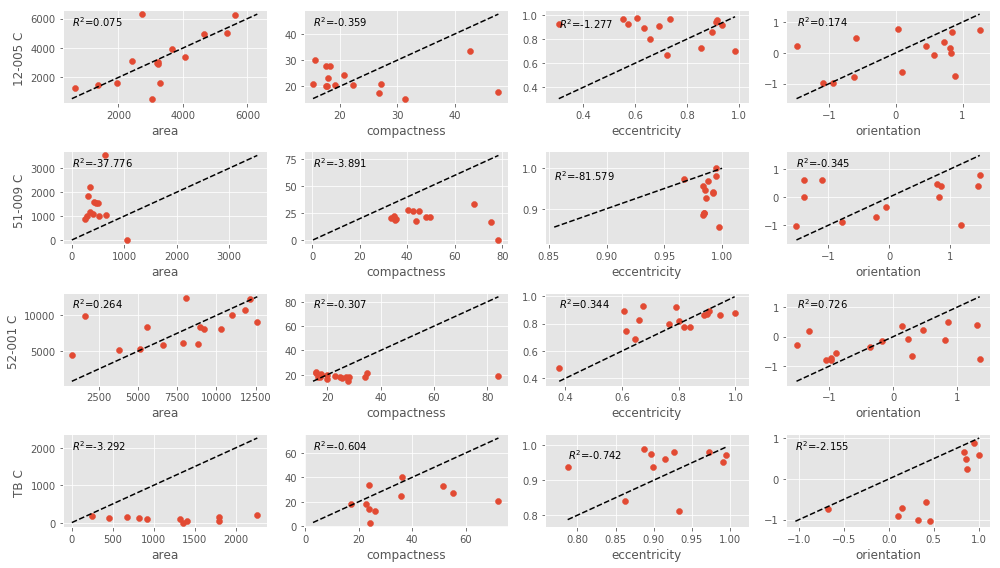

In [17]:
fig, axes = plt.subplots(ncols=len(columns), nrows=len(plot_files), figsize=(14, 2 * len(plot_files)))
# if not isinstance(axes, list):
#     axes = [axes]
for (_, row), axrow in zip(plot_files.iterrows(), axes):
    if row['model'] != 'C':
        continue
    y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))
    if isinstance(y, list):
        y = pd.concat(y)
        y_pred = pd.concat(y_pred)
    print(y.electrode.unique())
    idx = y['electrode'] == 'E01'
#     idx = np.logical_or(idx, y['electrode'] == 'B09')
#     idx = np.logical_or(y['electrode'] == 'C01', y['electrode'] == 'D03')
#     idx = np.logical_or(idx, y['electrode'] == 'D07')
    y = y[np.logical_not(idx)]
    y_pred = y_pred[np.logical_not(idx)]
    row['r2_area'] = sklm.r2_score(y['area'], np.nan_to_num(y_pred['area']))
    row['r2_compactness'] = sklm.r2_score(y['compactness'], np.nan_to_num(y_pred['compactness']))
    row['r2_eccentricity'] = sklm.r2_score(y['eccentricity'], np.nan_to_num(y_pred['eccentricity']))
    cond = y['area'] > 1000
    print(y[cond], y_pred[cond])
    for col, ax in zip(columns, axrow):
        ax.scatter(y[col], y_pred[col])
        minval = np.minimum(y[col].min(), y_pred[col].min())
        maxval = np.maximum(y[col].max(), y_pred[col].max())
        ax.plot([minval, maxval], [minval, maxval], 'k--')
        ax.set_xlabel(col)
        ax.text(minval, maxval, "$R^2$=%.3f" % float(row['r2_' + col]), va='top')
    axrow[0].set_ylabel('%s %s %s' % (row['subject'], row['model'],
                                      "adjust" if row['adjust_bias'] else ""))
#     break
fig.tight_layout()

In [18]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [19]:
y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))

In [20]:
for col in columns:
    df = pd.DataFrame({'y': y[col], 'y_hat': y_pred[col]})
    model = ols('y ~ y_hat', data=df).fit()
    anovaResults = anova_lm(model)
    print('')
    print(col)
    print(anovaResults)


area
           df        sum_sq        mean_sq         F    PR(>F)
y_hat     1.0  1.488484e+04   14884.843143  0.034741  0.856274
Residual  9.0  3.856119e+06  428457.704297       NaN       NaN

compactness
           df       sum_sq     mean_sq         F    PR(>F)
y_hat     1.0   343.731579  343.731579  1.167682  0.307982
Residual  9.0  2649.338326  294.370925       NaN       NaN

eccentricity
           df    sum_sq   mean_sq        F    PR(>F)
y_hat     1.0  0.001608  0.001608  0.41869  0.533745
Residual  9.0  0.034572  0.003841      NaN       NaN

orientation
           df    sum_sq   mean_sq          F    PR(>F)
y_hat     1.0  1.448616  1.448616  11.788966  0.007467
Residual  9.0  1.105911  0.122879        NaN       NaN


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
